In [3]:
import glob
glob.glob("../data/*.csv")

['../data/export_dataframe.csv']

# Import libraries

In [2]:
import os
import pandas as pd
import re
import random
import numpy as np

from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer

import pickle

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
file = "../data/export_dataframe.csv"
data = pd.read_csv(file)
data.head()

,id_str,text,created_at,polarity,user_location
0,1247302110938529793,"RT @RealCandaceO: Apparently, doctors and nurs...",2020-04-06 23:16:11,0,Arizona
1,1247302111093592065,RT @BiggBossBites: We clean oil spots on our c...,2020-04-06 23:16:11,0,ca
2,1247302110988972038,Everything about this angers me.,2020-04-06 23:16:11,0,NaN
3,1247302111274192896,RT @lizzkatherine_: BREAKING NEWS: Louisiana j...,2020-04-06 23:16:11,0,Orangeburg SC to Harlem NY
4,1247302111215394816,RT @BlondieVex: So let me get this straight......,2020-04-06 23:16:11,0,"Battle Creek, MI"


In [5]:
len(data)

31468

We can see that multiple tweets have more than one classification and we can see many classfications in the toxic comments, however we only need to classify between toxic and non-toxic comments.

In [14]:
data.dtypes

id_str            int64
text             object
created_at       object
polarity          int64
user_location    object
dtype: object

# Preprocessing

All the special chars will be deleted.   
The regular expressions (RE_PATTERNS) are for the more common words which can be written in multiple ways for the toxic comments.

In [38]:
special_chars = r"[^a-z0-9!@#\$%\^\&\*_\-,\.' ]"
RE_PATTERNS = {
    ' fuck':['(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)','(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            'feck ', ' fux ', 'f\*\*', 'f\-ing', 'f u u c', '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',' fu ',
            'f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f\.u\.', 'f###', 'f@ck', 'f u c k', 'f uck', 'f ck' ],
    ' ass ':['[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$', '[^a-z]anus', ' a\*s\*s', 
        '[^a-z]ass[^a-z ]', 'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s'],
    ' ass hole ':[' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole'],
    ' bitch ':['(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)', 'b!tch','bi\+ch', 'b!\+ch',
               'b[w]*i[t]*ch','biatch', 'bi\*\*h', 'bytch', 'b i t c h'],
    ' bastard ':['ba[s|z]+t[e|a]+rd'],
    ' dick ':[' dick[^aeiou]', 'deek', 'd i c k'],
    ' suck ':[ 'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'],
    ' cunt ':['c u n t'],
    ' bull shit ':[ 'bullsh\*t', 'bull\$hit'],
    ' idiot ':['i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)','idiots','i d i o t'],
    ' cock ':['[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'],
    ' dumb ':['(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'],
    ' shit ':['shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t'],
    ' shit hole ':['shythole'],
    ' retard ':['returd', 'retad', 'retard', 'wiktard', 'wikitud'],
    ' rape ':['raped'],
    ' dumb ass':['dumbass', 'dubass'],
    ' ass head':['butthead'],
    ' nigger ':['nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'],
    ' shut the fuck up': ['stfu'],
    ' pussy ': ['pussy[^c]', 'pusy', 'pussi[^l]', 'pusses'],
    ' faggot ':['faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',],
    ' mother fucker':[' motha ', ' motha f', ' mother f', 'motherucker'],
    ' whore ':['wh\*\*\*', 'w h o r e'],
    ' ':['h[\S]+//[\S]+', ' RT ']
}

In [39]:
class preprocessing(object):
    def __init__(self,special_chars, pattern):
        self.pattern = pattern
        self.special_chars = special_chars
    def cleanString(self,s):
        # remove special chars
        if self.special_chars is not None:
            s = re.sub(self.special_chars, ' ', s)
        #Delete users
        s= ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",s).split())
        s = s.replace("\\n", " ").replace("\n", " ")
        # Regular expressions
        pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
        s = pattern.sub(r"\1", s)
        tokenizer = TweetTokenizer()
        # Remove stop words
        stop_words = set(stopwords.words('english'))
        cleaned_words = [w for w in tokenizer.tokenize(s) if w not in stop_words]
        return " ".join(cleaned_words)

    def stemWords(self,sentence):
        stemmer, tokenizer = PorterStemmer(), TweetTokenizer()
        stemmed_words = [stemmer.stem(w) for w in tokenizer.tokenize(sentence)]
        return " ".join(stemmed_words)

    def cleanFrame(selfdev,frame):
        frame['clean_comment'] = frame.text.apply(selfdev.cleanString)

    def stemFrame(selfdev,frame):
        frame['stem_comment'] = frame.clean_comment.apply(selfdev.stemWords)




In [ ]:

Preprocessing=preprocessing(special_chars, RE_PATTERNS)
Preprocessing.cleanFrame(data)
Preprocessing.stemFrame(data)

The function cleanString hands with the special characters, regular expressions, stop words (for English).
The function stemWords stems the words already cleaned.
cleanFrame adds a new column "clean_comment", with the tweets already cleaned by applying the function cleanString
stemFrame got the new clean "clean_comment" from cleanFrame and apply in it stemWords, this is saved in a new column "stem_comment", this is the one which is going to be used for the classification.

In [8]:
data.head()


,id_str,text,created_at,polarity,user_location,clean_comment,stem_comment
0,1247302110938529793,"RT @RealCandaceO: Apparently, doctors and nurs...",2020-04-06 23:16:11,0,Arizona,eal andace pparently doctors nurses around wor...,eal andac pparent doctor nurs around world won...
1,1247302111093592065,RT @BiggBossBites: We clean oil spots on our c...,2020-04-06 23:16:11,0,ca,igg oss ites e clean oil spots cloths using de...,igg oss ite e clean oil spot cloth use deterg ...
2,1247302110988972038,Everything about this angers me.,2020-04-06 23:16:11,0,NaN,verything angers,veryth anger
3,1247302111274192896,RT @lizzkatherine_: BREAKING NEWS: Louisiana j...,2020-04-06 23:16:11,0,Orangeburg SC to Harlem NY,ouisiana released 19 data shows frican merican...,ouisiana releas 19 data show frican merican ac...
4,1247302111215394816,RT @BlondieVex: So let me get this straight......,2020-04-06 23:16:11,0,"Battle Creek, MI",londie ex let get straight oronavirus attack a...,londi ex let get straight oronaviru attack alm...


# Save data in a pickle

In [37]:
path = "../data/"
pickle.dump(data, open(path + 'covid_comments.pickle','wb'))

# Load data

In [13]:
path = "../data/"
data = pickle.load(open(path + 'covid_comments.pickle','rb'))
data.head()

,id_str,text,created_at,polarity,user_location,clean_comment,stem_comment
0,1247302110938529793,"RT @RealCandaceO: Apparently, doctors and nurs...",2020-04-06 23:16:11,0,Arizona,eal andace pparently doctors nurses around wor...,eal andac pparent doctor nurs around world won...
1,1247302111093592065,RT @BiggBossBites: We clean oil spots on our c...,2020-04-06 23:16:11,0,ca,igg oss ites e clean oil spots cloths using de...,igg oss ite e clean oil spot cloth use deterg ...
2,1247302110988972038,Everything about this angers me.,2020-04-06 23:16:11,0,NaN,verything angers,veryth anger
3,1247302111274192896,RT @lizzkatherine_: BREAKING NEWS: Louisiana j...,2020-04-06 23:16:11,0,Orangeburg SC to Harlem NY,ouisiana released 19 data shows frican merican...,ouisiana releas 19 data show frican merican ac...
4,1247302111215394816,RT @BlondieVex: So let me get this straight......,2020-04-06 23:16:11,0,"Battle Creek, MI",londie ex let get straight oronavirus attack a...,londi ex let get straight oronaviru attack alm...


# Vectorize

The data is split for training and test with a rate 80-20.

First we tokenize X_train and X_test

In [14]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(data.stem_comment))
list_tokenized = tokenizer.texts_to_sequences(data.stem_comment)

In [15]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized]
max(totalNumWords)

27

In [16]:
maxlen=400
V_data = pad_sequences(list_tokenized, maxlen=maxlen)
print(V_data.shape)

(31468, 400)


# Load the model

In [1]:
file_path="weights_base.best.hdf5"

from keras.models import load_model
model = load_model(file_path)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [138]:
text="i am happy"

classtest=preprocessing(special_chars, RE_PATTERNS)
text=classtest.cleanString(text)
text=classtest.stemWords(text)
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(data.stem_comment))
list_tokenized = tokenizer.texts_to_sequences([text])


In [139]:
maxlen=400
V_data = pad_sequences(list_tokenized, maxlen=maxlen)

# Classification

In [140]:
from sklearn.pipeline import Pipeline

y_pred = model.predict(V_data)
y_pred.sum()/len(y_pred)

0.07788601517677307

In [137]:
y_pred

array([[0.5390812]], dtype=float32)

In [20]:
k=0
for i,v in enumerate(list(y_pred.round())):
    #i: index, v: values
    data.polarity[i]=v
    if v==0:
        print(y_pred[i], " Positive")
    else:
        k+=1
        print(y_pred[i],data.text[i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[0.01362848]  Positive
[0.00302499]  Positive
[0.02338121]  Positive
[0.03182436]  Positive
[0.01640638]  Positive
[0.01362848]  Positive
[0.01368537]  Positive
[0.80902416] RT @BerniceKing: ...with humanity in mind.

MY STATEMENT REGARDING CO-CHAIRING #GEORGIA GOV. BRIAN KEMPS #CORONAVIRUS TASK FORCE COMMUNI
[0.0120284]  Positive
[0.0203837]  Positive
[0.08324528]  Positive
[0.00281968]  Positive
[0.0037783]  Positive
[0.00339252]  Positive
[0.02797486]  Positive
[0.19344884]  Positive
[0.00549929]  Positive
[0.05792258]  Positive
[0.00675238]  Positive
[0.04029261]  Positive
[0.02463439]  Positive
[0.01901633]  Positive
[0.00447212]  Positive
[0.00462047]  Positive
[0.0435384]  Positive
[0.00643764]  Positive
[0.00296917]  Positive
[0.00498393]  Positive
[0.00334683]  Positive
[0.98868644] Yes and gives you a false narrative about what's occurring.
[0.00228339]  Positive
[0.7151898] RT @WhiteHouse: LIVE: Press Briefing with Coronavirus Task Force https://t.co/Noma8NXmag
[0.01069186] 

[0.00627473]  Positive
[0.02518916]  Positive
[0.2686072]  Positive
[0.7142325] RT @CREWcrew: Wonder why Trump has been hawking hydroxychloroquine to fight coronavirus, despite the science?

Well, this might have a litt
[0.28653088]  Positive
[0.00354323]  Positive
[0.00261703]  Positive
[0.0091518]  Positive
[0.00592948]  Positive
[0.02213095]  Positive
[0.0027212]  Positive
[0.10463715]  Positive
[0.01911509]  Positive
[0.03276066]  Positive
[0.10454647]  Positive
[0.00972887]  Positive
[0.05817776]  Positive
[0.13349599]  Positive
[0.00304561]  Positive
[0.0120284]  Positive
[0.00630967]  Positive
[0.00627473]  Positive
[0.04650476]  Positive
[0.01548632]  Positive
[0.0157775]  Positive
[0.12299529]  Positive
[0.01934681]  Positive
[0.00252139]  Positive
[0.03467302]  Positive
[0.05248746]  Positive
[0.01458558]  Positive
[0.00344828]  Positive
[0.07458659]  Positive
[0.03538382]  Positive
[0.9239062] RT @politico: Marco Rubio is playing a key role in the coronavirus crisis. And he 

[0.01519272]  Positive
[0.8802972] RT @Rick_Sports10: With her travel softball season on hold. 9-year old Marshall, Illinois native  Jeighla McManus has turned her focus from
[0.02748429]  Positive
[0.00811727]  Positive
[0.14476833]  Positive
[0.00377934]  Positive
[0.00309546]  Positive
[0.00838669]  Positive
[0.92381144] RT @adriana_donati: These Losers! Reporters attacking Trump for wanting to saves lives and give Americans hope! Want to close down grocery
[0.01122724]  Positive
[0.0240074]  Positive
[0.00559837]  Positive
[0.00328248]  Positive
[0.00539406]  Positive
[0.01055681]  Positive
[0.0135535]  Positive
[0.02431952]  Positive
[0.00134898]  Positive
[0.02246481]  Positive
[0.01636952]  Positive
[0.00703143]  Positive
[0.00572922]  Positive
[0.0042864]  Positive
[0.07147538]  Positive
[0.59492093] RT @TomFitton: BREAKING: Leftist governor tries to cancel in-person election!  State Supreme Court says no!  Leftists demand last minute el
[0.12930231]  Positive
[0.00905097]  Pos

[0.12355537]  Positive
[0.00401093]  Positive
[0.908369] RT @US_FDA: On #WorldHealthDay, we give thanks to the hardworking health care workers in the United States and across the globe  especiall
[0.15637496]  Positive
[0.10292911]  Positive
[0.00466223]  Positive
[0.06756123]  Positive
[0.00536784]  Positive
[0.00536784]  Positive
[0.17732914]  Positive
[0.01149349]  Positive
[0.5212902] Medical care for people experiencing homelessness is so critical during this time.  Thank you to @Heart_to_Heart fo https://t.co/igsSw6lbRs
[0.0181521]  Positive
[0.95686567] RT @KidKool4U: I don't give a fk if #COVID19 is 100x worse than the complete overblown BS the globalist scum are pawning it off to be. Peop
[0.01326827]  Positive
[0.02875063]  Positive
[0.03735619]  Positive
[0.01333401]  Positive
[0.00485841]  Positive
[0.00775188]  Positive
[0.03394458]  Positive
[0.0013896]  Positive
[0.51556075] RT @tauriqmoosa: Viktor Orbn is treating the Covid-19 pandemic as his Reichstag fire, to push for

[0.00742491]  Positive
[0.07666608]  Positive
[0.01420146]  Positive
[0.02153668]  Positive
[0.00544941]  Positive
[0.00534535]  Positive
[0.006167]  Positive
[0.03182436]  Positive
[0.01330779]  Positive
[0.00572922]  Positive
[0.03105236]  Positive
[0.00130062]  Positive
[0.03182436]  Positive
[0.01801122]  Positive
[0.06840312]  Positive
[0.06815249]  Positive
[0.0174779]  Positive
[0.61900073] RT @YoungDems4Trump: The Media is just loving this #coronavirus pandemic. Watch them play crisis dress up with one reporter in a makeshift
[0.00158955]  Positive
[0.01085264]  Positive
[0.01304619]  Positive
[0.7486645] RT @gifdsports: Tracy Morgan really out here telling Hoda he's impregnating his wife 3 times...talking about Coronavirus sex role-playing .
[0.00142205]  Positive
[0.01057081]  Positive
[0.00661126]  Positive
[0.10384788]  Positive
[0.00811727]  Positive
[0.02380542]  Positive
[0.510608] RT @IanSams: Wow. NYT reports Trump himself has a financial stake in the French company th

[0.01226854]  Positive
[0.04774906]  Positive
[0.04233989]  Positive
[0.0042864]  Positive
[0.2779235]  Positive
[0.26458234]  Positive
[0.05240982]  Positive
[0.01842789]  Positive
[0.04253634]  Positive
[0.12355537]  Positive
[0.01499006]  Positive
[0.01390467]  Positive
[0.04485898]  Positive
[0.01714188]  Positive
[0.02049697]  Positive
[0.00276146]  Positive
[0.01207078]  Positive
[0.51136327] RT @MiaFarrow: There are over 300 different drug  trials in progress for covid-19. Why is Donald Trump pushing this one drug hydroxychloroq
[0.00208215]  Positive
[0.01425479]  Positive
[0.00263377]  Positive
[0.0020536]  Positive
[0.00263377]  Positive
[0.0043834]  Positive
[0.00905676]  Positive
[0.00450259]  Positive
[0.01068184]  Positive
[0.03067618]  Positive
[0.00580093]  Positive
[0.00314197]  Positive
[0.33463076]  Positive
[0.01437206]  Positive
[0.00212914]  Positive
[0.00772502]  Positive
[0.89004207] RT @LJMU: Were proud to be playing a small part in the huge national effort to 

[0.0047865]  Positive
[0.03250472]  Positive
[0.04731156]  Positive
[0.03502212]  Positive
[0.01474621]  Positive
[0.01900379]  Positive
[0.0110791]  Positive
[0.00593671]  Positive
[0.01590338]  Positive
[0.00699181]  Positive
[0.00693397]  Positive
[0.00725856]  Positive
[0.00780213]  Positive
[0.0078754]  Positive
[0.44441342]  Positive
[0.02294315]  Positive
[0.35363352]  Positive
[0.00118742]  Positive
[0.00733969]  Positive
[0.00411365]  Positive
[0.28648642]  Positive
[0.01212691]  Positive
[0.04639564]  Positive
[0.94469094] RT @MsMelChen: Can I ask why is this story not covered prominently?

"Trump admin announced additional $225 million in aid to help countrie
[0.00536983]  Positive
[0.00294197]  Positive
[0.02201387]  Positive
[0.0094092]  Positive
[0.01628291]  Positive
[0.20873727]  Positive
[0.01488514]  Positive
[0.9429159] RT @peterdaou: So #coronavirus showed us...

They CAN give everyone health care and a living wage.

They CAN forgive people's debts.

They
[0.0029967

[0.00837338]  Positive
[0.01594489]  Positive
[0.03741215]  Positive
[0.0093659]  Positive
[0.00406111]  Positive
[0.05991527]  Positive
[0.00785078]  Positive
[0.02560503]  Positive
[0.31761202]  Positive
[0.02919565]  Positive
[0.00389915]  Positive
[0.01289952]  Positive
[0.01272173]  Positive
[0.01422763]  Positive
[0.02069505]  Positive
[0.00997776]  Positive
[0.00361732]  Positive
[0.00871977]  Positive
[0.02369506]  Positive
[0.97434527] RT @TheRickWilson: From the very pro-Trump WSJ ed board:

The White House coronavirus briefings have become a boring show of President vs.
[0.01194415]  Positive
[0.02715073]  Positive
[0.01360839]  Positive
[0.00239547]  Positive
[0.06047175]  Positive
[0.0017078]  Positive
[0.01281804]  Positive
[0.00385512]  Positive
[0.16679448]  Positive
[0.00502316]  Positive
[0.04221683]  Positive
[0.01412007]  Positive
[0.06974316]  Positive
[0.01579903]  Positive
[0.00876777]  Positive
[0.00657272]  Positive
[0.01412959]  Positive
[0.00375371]  Positive

[0.00570583]  Positive
[0.01333912]  Positive
[0.4958541]  Positive
[0.03073662]  Positive
[0.00479273]  Positive
[0.01516601]  Positive
[0.00222826]  Positive
[0.00484537]  Positive
[0.00792553]  Positive
[0.03354628]  Positive
[0.25535852]  Positive
[0.00722542]  Positive
[0.03633761]  Positive
[0.00323272]  Positive
[0.00981868]  Positive
[0.0075829]  Positive
[0.02164032]  Positive
[0.00572375]  Positive
[0.00587955]  Positive
[0.23666692]  Positive
[0.09089317]  Positive
[0.01090553]  Positive
[0.03687581]  Positive
[0.07801633]  Positive
[0.96461004] The fuck is this call Pinkerton's time for some ass whooppings

https://t.co/3VpTC1H6dl
[0.00232169]  Positive
[0.07848251]  Positive
[0.86881405] Merkel says no to 'coronabonds' | Article [AMP] | Reuters https://t.co/solMjBIQG7 
[0.01412961]  Positive
[0.01495018]  Positive
[0.00636695]  Positive
[0.01805828]  Positive
[0.02608498]  Positive
[0.00268842]  Positive
[0.02261799]  Positive
[0.08628308]  Positive
[0.01426936]  Positive


[0.01541195]  Positive
[0.03115493]  Positive
[0.00375353]  Positive
[0.01996135]  Positive
[0.01051568]  Positive
[0.00640581]  Positive
[0.01307495]  Positive
[0.00928197]  Positive
[0.07902376]  Positive
[0.19508514]  Positive
[0.00434084]  Positive
[0.07574522]  Positive
[0.00755267]  Positive
[0.0066866]  Positive
[0.42242974]  Positive
[0.08649321]  Positive
[0.0021471]  Positive
[0.0360507]  Positive
[0.01996135]  Positive
[0.01259258]  Positive
[0.00143238]  Positive
[0.00294197]  Positive
[0.04136251]  Positive
[0.00244594]  Positive
[0.9688071] RT @_knucklebone: Twitter founder gives up a quarter of his wealth to his own COVID19 LLC

One day later: your ability to refuse us the r
[0.00370426]  Positive
[0.7324516] RT @Nick_Mosby: @GovLarryHogan Without racial data disaggregated by zip code, local authorities do not know what areas to target to allocat
[0.09558942]  Positive
[0.00722542]  Positive
[0.05239978]  Positive
[0.0031113]  Positive
[0.0272585]  Positive
[0.12969738] 

[0.9487769] RT @TeaPainUSA: Who did "Not See" this comin'? https://t.co/gWSlRAOwhk
[0.00783877]  Positive
[0.144953]  Positive
[0.00385985]  Positive
[0.00966232]  Positive
[0.00463657]  Positive
[0.02787851]  Positive
[0.01115342]  Positive
[0.0111475]  Positive
[0.01412959]  Positive
[0.00412484]  Positive
[0.00568592]  Positive
[0.04045559]  Positive
[0.01331324]  Positive
[0.79808456] RT @gcirtweets: @WESPicks Great question! Check out GCIRs recommendations on how philanthropy can support immigrant families and communiti
[0.00722542]  Positive
[0.02313858]  Positive
[0.02784261]  Positive
[0.01401474]  Positive
[0.04062275]  Positive
[0.44681546]  Positive
[0.01861696]  Positive
[0.02136708]  Positive
[0.08498345]  Positive
[0.00525446]  Positive
[0.00891859]  Positive
[0.00746898]  Positive
[0.00478127]  Positive
[0.03874119]  Positive
[0.008948]  Positive
[0.39817762]  Positive
[0.0209407]  Positive
[0.07829204]  Positive
[0.00296932]  Positive
[0.00523641]  Positive
[0.01261942]

[0.0162819]  Positive
[0.13399425]  Positive
[0.6882347] RT @PoschChristian: First experiences with the #COVID19 #AntibodyTest - here is what we found:

Observation 1: Getting immune to #COVID19
[0.05424765]  Positive
[0.00776599]  Positive
[0.02787851]  Positive
[0.01495018]  Positive
[0.0277204]  Positive
[0.0117294]  Positive
[0.00999736]  Positive
[0.04628555]  Positive
[0.00698223]  Positive
[0.02068764]  Positive
[0.20190565]  Positive
[0.00722542]  Positive
[0.00111313]  Positive
[0.01996135]  Positive
[0.00239471]  Positive
[0.29142946]  Positive
[0.06556216]  Positive
[0.01410835]  Positive
[0.00252023]  Positive
[0.01092265]  Positive
[0.00848894]  Positive
[0.04642615]  Positive
[0.01942807]  Positive
[0.00985434]  Positive
[0.01213233]  Positive
[0.02364438]  Positive
[0.00644566]  Positive
[0.00252968]  Positive
[0.07109869]  Positive
[0.01179796]  Positive
[0.09612299]  Positive
[0.10557328]  Positive
[0.02715073]  Positive
[0.00408558]  Positive
[0.01996135]  Positive
[0

[0.00771253]  Positive
[0.0761878]  Positive
[0.00480641]  Positive
[0.01942807]  Positive
[0.00427012]  Positive
[0.09626392]  Positive
[0.00681112]  Positive
[0.00512977]  Positive
[0.03028147]  Positive
[0.03594706]  Positive
[0.00421793]  Positive
[0.00450034]  Positive
[0.0188158]  Positive
[0.02247537]  Positive
[0.03502212]  Positive
[0.72539514] RT @darrenrovell: Wimbledon reportedly paid $2 million a year for pandemic insurance for the last 17 years 

(Total: $34 Million)

For this
[0.7191467] RT @juliettekayyem: Wimbledon paid for pandemic insurance for the last 17 years.  Due to 2020 #coronavirus cancellation, they will receive
[0.00645313]  Positive
[0.1328656]  Positive
[0.05158781]  Positive
[0.01491336]  Positive
[0.00582649]  Positive
[0.0125531]  Positive
[0.04546114]  Positive
[0.00440743]  Positive
[0.01115532]  Positive
[0.04732354]  Positive
[0.01153006]  Positive
[0.03453379]  Positive
[0.01585133]  Positive
[0.0285035]  Positive
[0.0325325]  Positive
[0.00793538]

[0.01996135]  Positive
[0.00383362]  Positive
[0.00795924]  Positive
[0.01741523]  Positive
[0.03252407]  Positive
[0.05319882]  Positive
[0.0171976]  Positive
[0.00643503]  Positive
[0.00225557]  Positive
[0.00571417]  Positive
[0.0137303]  Positive
[0.00081537]  Positive
[0.00749648]  Positive
[0.00405003]  Positive
[0.03266207]  Positive
[0.00801874]  Positive
[0.00337125]  Positive
[0.03381641]  Positive
[0.0341624]  Positive
[0.00448481]  Positive
[0.01213233]  Positive
[0.01412217]  Positive
[0.00275829]  Positive
[0.00903734]  Positive
[0.02136708]  Positive
[0.00899256]  Positive
[0.0039202]  Positive
[0.0326561]  Positive
[0.01606248]  Positive
[0.01177921]  Positive
[0.00693917]  Positive
[0.03258034]  Positive
[0.00627653]  Positive
[0.5393384] The GOP cruelty is how the view their power.
[0.0035669]  Positive
[0.00379027]  Positive
[0.9297026] Corporations are playing an important role in supporting the efforts to flatten the curve

Our President https://t.co/WPnJwBh299
[0.

[0.01718979]  Positive
[0.5601938] RT @Emolclause: #BREAKING:Now the DANGEROUS @FoxNews,already slapped with a lawsuit for #COVID19 MISINFORMATION,is pushing SOME MORE misin
[0.00865939]  Positive
[0.08240277]  Positive
[0.00452766]  Positive
[0.0044486]  Positive
[0.00337125]  Positive
[0.00628134]  Positive
[0.00309294]  Positive
[0.06490867]  Positive
[0.1689707]  Positive
[0.01948221]  Positive
[0.12891646]  Positive
[0.02902597]  Positive
[0.03721812]  Positive
[0.00530855]  Positive
[0.6668663] Mmmmm, why is it that the Democrats are the ones pushing this manure?

https://t.co/3CN2Kw3Mwr
[0.00915048]  Positive
[0.02105111]  Positive
[0.02366764]  Positive
[0.00922607]  Positive
[0.00908465]  Positive
[0.00405342]  Positive
[0.00350782]  Positive
[0.02120886]  Positive
[0.00412742]  Positive
[0.00294704]  Positive
[0.6688905] ABOUT TIME BUT THEN IT SHOULD STAY BLOCKED AS THEY ARE PURELY GRIFTING PROPAGANDISTS
[0.02537457]  Positive
[0.00275163]  Positive
[0.00471664]  Positive
[0.

[0.00332574]  Positive
[0.09695137]  Positive
[0.00483603]  Positive
[0.01590972]  Positive
[0.00508296]  Positive
[0.00704545]  Positive
[0.00678923]  Positive
[0.00343679]  Positive
[0.01208781]  Positive
[0.0018344]  Positive
[0.08684715]  Positive
[0.03446448]  Positive
[0.05693743]  Positive
[0.01446843]  Positive
[0.03729706]  Positive
[0.03098494]  Positive
[0.02211708]  Positive
[0.02848363]  Positive
[0.09695137]  Positive
[0.23132274]  Positive
[0.84266645] RT @latimeshealth: Rita Wilson took chloroquine to fight COVID-19 and didn't like what it did to her https://t.co/ZhxDIh0AAp
[0.06811575]  Positive
[0.99367625] PC mad.Medical science now gives clear stats:Obesity tops most lists of dangerous underlying conditions of C-19 dea https://t.co/3LrF15KqZv
[0.0507468]  Positive
[0.02966917]  Positive
[0.01614352]  Positive
[0.24356142]  Positive
[0.00456927]  Positive
[0.00437445]  Positive
[0.1826232]  Positive
[0.13410912]  Positive
[0.00350935]  Positive
[0.00686482]  Positive

[0.93494534] California's Newsom announces $125M fund to give coronavirus stimulus checks to immigrants in state illegally
 https://t.co/s2o2mkySmM
[0.01714006]  Positive
[0.6473014] RT @DavidColeACLU: BREAKING:  We just won a preliminary injunction in Texas.  All voters get to vote by mail in the primary.  No individual
[0.00550013]  Positive
[0.00766385]  Positive
[0.020354]  Positive
[0.0290916]  Positive
[0.03244617]  Positive
[0.02848363]  Positive
[0.00496861]  Positive
[0.0021124]  Positive
[0.00213286]  Positive
[0.26077333]  Positive
[0.00466394]  Positive
[0.9529218] RT @JAMA_current: Study suggests higher rates of co-infection between #SARSCoV2 and other respiratory pathogens than previously reported ht
[0.04251799]  Positive
[0.00384712]  Positive
[0.02848363]  Positive
[0.00433881]  Positive
[0.02749316]  Positive
[0.03501719]  Positive
[0.45727703]  Positive
[0.01378233]  Positive
[0.14412542]  Positive
[0.00894652]  Positive
[0.08399709]  Positive
[0.00987795]  Positive


[0.00814176]  Positive
[0.3873609]  Positive
[0.00344736]  Positive
[0.00466394]  Positive
[0.5154157] PLANDEMIC: Coronavirus Origin EXPOSED at Trump White House Press Briefing https://t.co/1eAHrnkC5I via @YouTube
[0.00248074]  Positive
[0.04339318]  Positive
[0.01403606]  Positive
[0.00281285]  Positive
[0.01353449]  Positive
[0.00926346]  Positive
[0.00701373]  Positive
[0.00660724]  Positive
[0.00659718]  Positive
[0.00504375]  Positive
[0.02898041]  Positive
[0.01357722]  Positive
[0.03073213]  Positive
[0.02917929]  Positive
[0.01967772]  Positive
[0.00900256]  Positive
[0.00697661]  Positive
[0.02182756]  Positive
[0.00507769]  Positive
[0.0112428]  Positive
[0.03907846]  Positive
[0.00260382]  Positive
[0.03694365]  Positive
[0.00504375]  Positive
[0.9394178] RT @AmyMcGrathKY: It's no surprise that McConnell inserted a $90 billion provision in the coronavirus package giving even more tax breaks t
[0.00483507]  Positive
[0.0068117]  Positive
[0.00784201]  Positive
[0.17906539]  P

[0.39527133]  Positive
[0.00828392]  Positive
[0.05693743]  Positive
[0.00188175]  Positive
[0.02170252]  Positive
[0.9337198] California's Newsom announces $125M fund to give coronavirus stimulus checks to immigrants in state illegally https://t.co/01qxAmauiw
[0.02464896]  Positive
[0.1434075]  Positive
[0.0186132]  Positive
[0.06598105]  Positive
[0.00267851]  Positive
[0.02917929]  Positive
[0.02195921]  Positive
[0.00234635]  Positive
[0.00678923]  Positive
[0.02840841]  Positive
[0.01399364]  Positive
[0.01759115]  Positive
[0.00401073]  Positive
[0.01486205]  Positive
[0.00591206]  Positive
[0.00259506]  Positive
[0.02240738]  Positive
[0.02848363]  Positive
[0.00868381]  Positive
[0.01007571]  Positive
[0.12591508]  Positive
[0.00411716]  Positive
[0.02639637]  Positive
[0.01713994]  Positive
[0.13410912]  Positive
[0.02049522]  Positive
[0.02378727]  Positive
[0.00666384]  Positive
[0.01730279]  Positive
[0.02528629]  Positive
[0.06899957]  Positive
[0.0608542]  Positive
[0.699

[0.02034488]  Positive
[0.04538877]  Positive
[0.03178902]  Positive
[0.01227803]  Positive
[0.08283412]  Positive
[0.01460782]  Positive
[0.2675123]  Positive
[0.28187442]  Positive
[0.05800496]  Positive
[0.02838553]  Positive
[0.01481318]  Positive
[0.00332574]  Positive
[0.01273464]  Positive
[0.00678923]  Positive
[0.00348851]  Positive
[0.03804591]  Positive
[0.00317365]  Positive
[0.09695137]  Positive
[0.00311816]  Positive
[0.0081038]  Positive
[0.16672556]  Positive
[0.00320694]  Positive
[0.88735783] RT @cjtruth: The Democrat Party of 2020

California's Newsom announces $125M fund to give coronavirus stimulus checks to immigrants in st
[0.38377255]  Positive
[0.00780573]  Positive
[0.00482102]  Positive
[0.0133157]  Positive
[0.00258234]  Positive
[0.00718166]  Positive
[0.06192021]  Positive
[0.01577066]  Positive
[0.00417539]  Positive
[0.02617088]  Positive
[0.09695137]  Positive
[0.0096534]  Positive
[0.03677562]  Positive
[0.7068555] RT @Goss30Goss: I guarantee you the 

[0.00662396]  Positive
[0.00979095]  Positive
[0.15983477]  Positive
[0.00912925]  Positive
[0.0348864]  Positive
[0.01171168]  Positive
[0.01629422]  Positive
[0.06581452]  Positive
[0.01713651]  Positive
[0.00452184]  Positive
[0.11483262]  Positive
[0.09458902]  Positive
[0.00603342]  Positive
[0.15044126]  Positive
[0.03061988]  Positive
[0.16171877]  Positive
[0.00318057]  Positive
[0.09695137]  Positive
[0.0049731]  Positive
[0.00593479]  Positive
[0.0112428]  Positive
[0.09933963]  Positive
[0.12404389]  Positive
[0.01579028]  Positive
[0.01156703]  Positive
[0.01300251]  Positive
[0.00877393]  Positive
[0.20582248]  Positive
[0.6617357] RT @MattWhitaker46: Thinking about whether legally @CNN should file a Foreign Agent Registration Act (FARA) report with @TheJusticeDept
Wha
[0.0082961]  Positive
[0.0386977]  Positive
[0.0190648]  Positive
[0.0260103]  Positive
[0.02242971]  Positive
[0.00533407]  Positive
[0.00384619]  Positive
[0.15166633]  Positive
[0.0144146]  Positive
[0.99

[0.00616717]  Positive
[0.03804591]  Positive
[0.03804591]  Positive
[0.00651157]  Positive
[0.00311816]  Positive
[0.02917929]  Positive
[0.09652454]  Positive
[0.01266014]  Positive
[0.00682564]  Positive
[0.0226883]  Positive
[0.01269055]  Positive
[0.0359598]  Positive
[0.87476134] RT @cjtruth: Zerohedge got banned from Twitter for posting this article
Trump Says US 'Thoroughly Examining' Possibility Virus Leaked Fro
[0.06619842]  Positive
[0.02062857]  Positive
[0.0058174]  Positive
[0.04251799]  Positive
[0.01897445]  Positive
[0.00315294]  Positive
[0.0352]  Positive
[0.00485332]  Positive
[0.13024758]  Positive
[0.0119214]  Positive
[0.01302376]  Positive
[0.00689795]  Positive
[0.6473014] RT @DavidColeACLU: BREAKING:  We just won a preliminary injunction in Texas.  All voters get to vote by mail in the primary.  No individual
[0.00261918]  Positive
[0.05909694]  Positive
[0.6473014] RT @DavidColeACLU: BREAKING:  We just won a preliminary injunction in Texas.  All voters get to

[0.01662543]  Positive
[0.00928708]  Positive
[0.00705393]  Positive
[0.05776414]  Positive
[0.13006768]  Positive
[0.1883471]  Positive
[0.00714351]  Positive
[0.0106334]  Positive
[0.0654861]  Positive
[0.38472608]  Positive
[0.84266645] RT @latimeshealth: Rita Wilson took chloroquine to fight COVID-19 and didn't like what it did to her https://t.co/ZhxDIh0AAp
[0.23530352]  Positive
[0.01223886]  Positive
[0.00641836]  Positive
[0.02902354]  Positive
[0.26023275]  Positive
[0.3406015]  Positive
[0.00356636]  Positive
[0.6553984] RT @CBSNews: Staff at a Florida animal shelter cheer from empty cages  as all of the pups from one of its kennels were placed in homes ami
[0.01779194]  Positive
[0.00650459]  Positive
[0.03413429]  Positive
[0.00570591]  Positive
[0.06619842]  Positive
[0.9394178] RT @AmyMcGrathKY: It's no surprise that McConnell inserted a $90 billion provision in the coronavirus package giving even more tax breaks t
[0.00467115]  Positive
[0.13410912]  Positive
[0.01692968

[0.01580806]  Positive
[0.01764164]  Positive
[0.00757657]  Positive
[0.00812085]  Positive
[0.08201002]  Positive
[0.13657047]  Positive
[0.00341318]  Positive
[0.01561441]  Positive
[0.00653959]  Positive
[0.07964318]  Positive
[0.0041855]  Positive
[0.00490509]  Positive
[0.00976574]  Positive
[0.10031939]  Positive
[0.0014247]  Positive
[0.5533382] RT @Emolclause: #BREAKING:Turns out @foxnews lawyers have filed a motion to DISMISS the #COVID19 lawsuit against them arguing that #FoxNews
[0.00382368]  Positive
[0.00368059]  Positive
[0.00234254]  Positive
[0.02898041]  Positive
[0.01865547]  Positive
[0.031604]  Positive
[0.02033701]  Positive
[0.07994346]  Positive
[0.00617388]  Positive
[0.06061225]  Positive
[0.00433881]  Positive
[0.04521509]  Positive
[0.01759115]  Positive
[0.67015433] RT @WhiteHouse: Press Briefing with Coronavirus Task Force https://t.co/yKjFhR4TfY
[0.01016955]  Positive
[0.00618022]  Positive
[0.00982693]  Positive
[0.0658297]  Positive
[0.01758112]  Positiv

[0.16755345]  Positive
[0.002455]  Positive
[0.05405692]  Positive
[0.01401236]  Positive
[0.02070475]  Positive
[0.00753072]  Positive
[0.01627819]  Positive
[0.00227009]  Positive
[0.01693729]  Positive
[0.06863677]  Positive
[0.01301246]  Positive
[0.03738211]  Positive
[0.01735728]  Positive
[0.00991134]  Positive
[0.03581771]  Positive
[0.03396983]  Positive
[0.00280097]  Positive
[0.56607884] RT @true_pundit: Study: Coronavirus Fatality Rate Lower than Expected, Close to Flus 0.1% https://t.co/EmQse1JXHI
[0.0038355]  Positive
[0.03035906]  Positive
[0.01819695]  Positive
[0.9547954] RT @ABCscience: It is possible to catch coronavirus through the air, experts say.

But there are some simple precautions you can take to pr
[0.02547938]  Positive
[0.00379213]  Positive
[0.6617357] RT @MattWhitaker46: Thinking about whether legally @CNN should file a Foreign Agent Registration Act (FARA) report with @TheJusticeDept
Wha
[0.0114441]  Positive
[0.00877757]  Positive
[0.14934285]  Positiv

[0.01366206]  Positive
[0.00464456]  Positive
[0.00262635]  Positive
[0.16672555]  Positive
[0.05162855]  Positive
[0.00643879]  Positive
[0.07426541]  Positive
[0.00534287]  Positive
[0.01355082]  Positive
[0.21474755]  Positive
[0.00317775]  Positive
[0.0543989]  Positive
[0.03080898]  Positive
[0.09695137]  Positive
[0.0070907]  Positive
[0.01730279]  Positive
[0.01378339]  Positive
[0.00259506]  Positive
[0.20177351]  Positive
[0.06751455]  Positive
[0.0249325]  Positive
[0.06709306]  Positive
[0.00814329]  Positive
[0.00850409]  Positive
[0.00296499]  Positive
[0.01049767]  Positive
[0.03127098]  Positive
[0.00521857]  Positive
[0.02032049]  Positive
[0.01367425]  Positive
[0.9472958] RT @laxswamy: This @TheAtlantic piece has so many great lines. Here are a few:
Its like everything we give to patients, were in short su
[0.02604309]  Positive
[0.02950509]  Positive
[0.03371319]  Positive
[0.10665067]  Positive
[0.0658297]  Positive
[0.00379213]  Positive
[0.17623276]  Positive
[0.0

[0.00511927]  Positive
[0.6473014] RT @DavidColeACLU: BREAKING:  We just won a preliminary injunction in Texas.  All voters get to vote by mail in the primary.  No individual
[0.0112428]  Positive
[0.0142876]  Positive
[0.16070002]  Positive
[0.01580806]  Positive
[0.00633804]  Positive
[0.00308653]  Positive
[0.00502242]  Positive
[0.8696905] RT @MintPressNews: SPECIAL REPORT:Despite leaving nearly every other sector of the economy in ruins, the #COVID19 pandemic has been a windf
[0.06492038]  Positive
[0.01693729]  Positive
[0.03713743]  Positive
[0.01392208]  Positive
[0.01275888]  Positive
[0.00430245]  Positive
[0.02042074]  Positive
[0.01778072]  Positive
[0.03207612]  Positive
[0.02747065]  Positive
[0.00117796]  Positive
[0.00379213]  Positive
[0.01691383]  Positive
[0.03223107]  Positive
[0.7264331] Get to know the special PressPad's offer for publishers in the time of #COVID19 https://t.co/oFkpBsvafo https://t.co/UigBWvHfmj
[0.00307255]  Positive
[0.10969366]  Positive
[0.027

[0.04251799]  Positive
[0.00530898]  Positive
[0.8945904] RT @PLily16: RT if You want to see this ass fucked !

https://t.co/bHS8ZCxal6 

#onlyfans #porn  #amateur #latina #babe #sellingn
[0.00403604]  Positive
[0.01961827]  Positive
[0.0041855]  Positive
[0.17289722]  Positive
[0.0103401]  Positive
[0.04525591]  Positive
[0.03420689]  Positive
[0.00809328]  Positive
[0.00355363]  Positive
[0.01630449]  Positive
[0.00915836]  Positive
[0.01518061]  Positive
[0.13156784]  Positive
[0.00587186]  Positive
[0.0025465]  Positive
[0.00318797]  Positive
[0.00894652]  Positive
[0.67015433] RT @WhiteHouse: Press Briefing with Coronavirus Task Force https://t.co/yKjFhR4TfY
[0.04070887]  Positive
[0.0196649]  Positive
[0.00523986]  Positive
[0.03086188]  Positive
[0.04251799]  Positive
[0.02355954]  Positive
[0.01367425]  Positive
[0.0097754]  Positive
[0.00699567]  Positive
[0.01104657]  Positive
[0.02615174]  Positive
[0.01511862]  Positive
[0.01455704]  Positive
[0.00655667]  Positive
[0.01057

[0.06038273]  Positive
[0.06128869]  Positive
[0.39862362]  Positive
[0.03536413]  Positive
[0.02314081]  Positive
[0.0097754]  Positive
[0.00446535]  Positive
[0.09695137]  Positive
[0.01442612]  Positive
[0.01124706]  Positive
[0.45727703]  Positive
[0.03343647]  Positive
[0.06863677]  Positive
[0.01734153]  Positive
[0.00460319]  Positive
[0.06953941]  Positive
[0.21474755]  Positive
[0.00662631]  Positive
[0.03790855]  Positive
[0.00575142]  Positive
[0.00764449]  Positive
[0.01659861]  Positive
[0.5112624] AIRWALL RX Transform your bedroom into a #Covid19 proof safe space! #WhitShue #Monsterfunders 

Please Help #Fund T https://t.co/Fvz22Cgb9Z
[0.11900146]  Positive
[0.00454032]  Positive
[0.00790868]  Positive
[0.00935402]  Positive
[0.01854731]  Positive
[0.15318185]  Positive
[0.0956203]  Positive
[0.00859769]  Positive
[0.633553] RT @mayawiley: Im ignoring the #TrumpPressConf because it doesnt feed the hungry, get help to small businesses, especially the little mom
[0.22125497

[0.00350522]  Positive
[0.00590665]  Positive
[0.00365096]  Positive
[0.0093042]  Positive
[0.05803024]  Positive
[0.16672555]  Positive
[0.00486804]  Positive
[0.15621652]  Positive
[0.04168993]  Positive
[0.00428844]  Positive
[0.00473148]  Positive
[0.00362388]  Positive
[0.00459711]  Positive
[0.08568686]  Positive
[0.2014277]  Positive
[0.0637587]  Positive
[0.24125813]  Positive
[0.00311816]  Positive
[0.01253551]  Positive
[0.01124634]  Positive
[0.00719566]  Positive
[0.00757657]  Positive
[0.07691394]  Positive
[0.02900048]  Positive
[0.95404655] RT @twmentality1: Dumb as fuck Michigan Republicans decided to gather at the state capital to insist that the economy be opened up by givin
[0.2014277]  Positive
[0.2014277]  Positive
[0.00832679]  Positive
[0.08921808]  Positive
[0.00398881]  Positive
[0.22684014]  Positive
[0.01277816]  Positive
[0.02706683]  Positive
[0.00521074]  Positive
[0.02706683]  Positive
[0.016527]  Positive
[0.0622027]  Positive
[0.04085099]  Positive
[0.0

[0.51396745] RT @billboard: From #OneDirection's 'One Direction: This Is Us' to #LadyGaga's 'Gaga: Five Foot Two,' here is a list of music &amp; concert fil
[0.00206281]  Positive
[0.01647246]  Positive
[0.00307255]  Positive
[0.34337083]  Positive
[0.01137164]  Positive
[0.02898041]  Positive
[0.38710198]  Positive
[0.01182982]  Positive
[0.8725013] RT @Steve_ofPA: @PressSec @realDonaldTrump @MSNBC @CNN Facts matter. Trump has lied about #coronavirus
from the beginning. Americans lives
[0.0267828]  Positive
[0.00551839]  Positive
[0.01338438]  Positive
[0.0543458]  Positive
[0.00483037]  Positive
[0.0637587]  Positive
[0.16672555]  Positive
[0.00606005]  Positive
[0.03281422]  Positive
[0.01334121]  Positive
[0.02849638]  Positive
[0.01403606]  Positive
[0.8057176] RT @jtLOL: So can lying to the world about it and letting it spread unabated. The WHO can shut the fuck up. https://t.co/63BY38scoz
[0.8278787] @DailyCaller @AndrewKerrNC So What?  Worry about the Stupid President that does

[0.0061806]  Positive
[0.01456161]  Positive
[0.01920516]  Positive
[0.01386423]  Positive
[0.66117543] RT @merlins_girl: From the #WTF files.... This POS shouldve been indicted for the Fast &amp; Furious scandal but was protected by Hussein. Now
[0.00567223]  Positive
[0.01281987]  Positive
[0.66173583] RT @MattWhitaker46: Thinking about whether legally @CNN should file a Foreign Agent Registration Act (FARA) report with @TheJusticeDept
Wha
[0.02684583]  Positive
[0.02547938]  Positive
[0.03618399]  Positive
[0.0264245]  Positive
[0.00200288]  Positive
[0.05287628]  Positive
[0.02408537]  Positive
[0.01980864]  Positive
[0.12647611]  Positive
[0.00888917]  Positive
[0.0061806]  Positive
[0.01649835]  Positive
[0.01343527]  Positive
[0.02387589]  Positive
[0.03354681]  Positive
[0.0513083]  Positive
[0.84266645] RT @latimeshealth: Rita Wilson took chloroquine to fight COVID-19 and didn't like what it did to her https://t.co/ZhxDIh0AAp
[0.16840623]  Positive
[0.0061806]  Positive
[0.039

[0.00741462]  Positive
[0.0112428]  Positive
[0.00678923]  Positive
[0.05654979]  Positive
[0.0106663]  Positive
[0.01384177]  Positive
[0.0272595]  Positive
[0.01767556]  Positive
[0.0637587]  Positive
[0.02848528]  Positive
[0.00224017]  Positive
[0.66117543] RT @merlins_girl: From the #WTF files.... This POS shouldve been indicted for the Fast &amp; Furious scandal but was protected by Hussein. Now
[0.16026217]  Positive
[0.00621318]  Positive
[0.01941807]  Positive
[0.00726971]  Positive
[0.03250549]  Positive
[0.01013727]  Positive
[0.02377147]  Positive
[0.0127489]  Positive
[0.00907638]  Positive
[0.0061806]  Positive
[0.01306224]  Positive
[0.00979676]  Positive
[0.00711755]  Positive
[0.03007566]  Positive
[0.00549781]  Positive
[0.00930083]  Positive
[0.06751455]  Positive
[0.0244847]  Positive
[0.03261279]  Positive
[0.13410912]  Positive
[0.00517574]  Positive
[0.01354845]  Positive
[0.00889481]  Positive
[0.00711755]  Positive
[0.00566044]  Positive
[0.00311816]  Positive


[0.00583067]  Positive
[0.01556609]  Positive
[0.00824848]  Positive
[0.02408537]  Positive
[0.06852067]  Positive
[0.00564609]  Positive
[0.03589253]  Positive
[0.03677709]  Positive
[0.00535804]  Positive
[0.18483135]  Positive
[0.01519738]  Positive
[0.01403606]  Positive
[0.00215733]  Positive
[0.00826567]  Positive
[0.01185884]  Positive
[0.00442643]  Positive
[0.00746931]  Positive
[0.00417701]  Positive
[0.04542311]  Positive
[0.00339802]  Positive
[0.0061806]  Positive
[0.00856961]  Positive
[0.00894652]  Positive
[0.09695137]  Positive
[0.03432744]  Positive
[0.11222836]  Positive
[0.00704545]  Positive
[0.8913589] RT @AdrianE1337: Hey guys special thanks to community member @kasaundratara for donating to the next giveaway! Picking 1 winner and giving
[0.02854992]  Positive
[0.60145575] RT @abc7rachel: LONG BEACH UPDATE: First homeless patient tests positive for COVID-19. To date, 379 people have tested positive for coronav
[0.05128327]  Positive
[0.00225718]  Positive
[0.0454

[0.10157737]  Positive
[0.6617357] RT @MattWhitaker46: Thinking about whether legally @CNN should file a Foreign Agent Registration Act (FARA) report with @TheJusticeDept
Wha
[0.37571716]  Positive
[0.13787597]  Positive
[0.09014963]  Positive
[0.00265383]  Positive
[0.05693743]  Positive
[0.00757657]  Positive
[0.0395872]  Positive
[0.00667256]  Positive
[0.00943726]  Positive
[0.03854069]  Positive
[0.015994]  Positive
[0.03165185]  Positive
[0.2077056]  Positive
[0.04062385]  Positive
[0.02415889]  Positive
[0.09012276]  Positive
[0.00318057]  Positive
[0.03057227]  Positive
[0.01218701]  Positive
[0.0061806]  Positive
[0.01515243]  Positive
[0.00439865]  Positive
[0.00486128]  Positive
[0.01598821]  Positive
[0.16549973]  Positive
[0.633553] RT @mayawiley: Im ignoring the #TrumpPressConf because it doesnt feed the hungry, get help to small businesses, especially the little mom
[0.888253] RT @Here4Trump2020: California's Newsom announces $125M fund to give coronavirus stimulus check

[0.01474955]  Positive
[0.00509277]  Positive
[0.00314141]  Positive
[0.0355387]  Positive
[0.03396983]  Positive
[0.01892174]  Positive
[0.00478243]  Positive
[0.05461733]  Positive
[0.00478243]  Positive
[0.0086287]  Positive
[0.09753991]  Positive
[0.0071115]  Positive
[0.39728343]  Positive
[0.00330492]  Positive
[0.08765442]  Positive
[0.8548757] RT @_SemaHernandez_: Keep fucking around and youre gonna find out how ugly this is going to get.

We have nothing left to lose.

Prepare
[0.05693743]  Positive
[0.08921808]  Positive
[0.06080309]  Positive
[0.00495095]  Positive
[0.0455551]  Positive
[0.01238727]  Positive
[0.11168976]  Positive
[0.01590972]  Positive
[0.01340952]  Positive
[0.22311419]  Positive
[0.02123775]  Positive
[0.08911645]  Positive
[0.0061806]  Positive
[0.13303098]  Positive
[0.09695137]  Positive
[0.02515162]  Positive
[0.06010153]  Positive
[0.00555663]  Positive
[0.18262313]  Positive
[0.01230928]  Positive
[0.0114441]  Positive
[0.01428752]  Positive
[0.001

[0.00174655]  Positive
[0.0061806]  Positive
[0.01664644]  Positive
[0.00283943]  Positive
[0.02251958]  Positive
[0.00778843]  Positive
[0.01129086]  Positive
[0.0028866]  Positive
[0.02128209]  Positive
[0.03533249]  Positive
[0.00434558]  Positive
[0.0097754]  Positive
[0.02457178]  Positive
[0.0049916]  Positive
[0.01778072]  Positive
[0.01833513]  Positive
[0.03509719]  Positive
[0.12001891]  Positive
[0.00363536]  Positive
[0.0172466]  Positive
[0.6473014] RT @DavidColeACLU: BREAKING:  We just won a preliminary injunction in Texas.  All voters get to vote by mail in the primary.  No individual
[0.00277313]  Positive
[0.01085335]  Positive
[0.00678923]  Positive
[0.01196601]  Positive
[0.00994129]  Positive
[0.06922466]  Positive
[0.02312099]  Positive
[0.26370934]  Positive
[0.01406611]  Positive
[0.00857617]  Positive
[0.00235515]  Positive
[0.00462404]  Positive
[0.90088046] RT @Neoavatara: This shows that @NickKristof really isn't serious on the science. 

Kristof needs to exp

[0.06751455]  Positive
[0.07895083]  Positive
[0.00391256]  Positive
[0.06598105]  Positive
[0.06636375]  Positive
[0.0045373]  Positive
[0.04922634]  Positive
[0.06709306]  Positive
[0.03828727]  Positive
[0.02848363]  Positive
[0.913282] RT @PressSec: While CNN accuses the coronavirus briefings of being propaganda, they are now actively defending Chinas coronavirus respon
[0.00744842]  Positive
[0.00522541]  Positive
[0.01468436]  Positive
[0.04104246]  Positive
[0.00433881]  Positive
[0.03496919]  Positive
[0.00433881]  Positive
[0.10969366]  Positive
[0.00845368]  Positive
[0.00921252]  Positive
[0.01044273]  Positive
[0.01818512]  Positive
[0.1005106]  Positive
[0.06519812]  Positive
[0.12946759]  Positive
[0.00563334]  Positive
[0.00211238]  Positive
[0.02882874]  Positive
[0.02445301]  Positive
[0.00298747]  Positive
[0.01403606]  Positive
[0.00620991]  Positive
[0.02898041]  Positive
[0.0100555]  Positive
[0.0086754]  Positive
[0.12601481]  Positive
[0.01299716]  Positive
[0.00

[0.00480427]  Positive
[0.08441306]  Positive
[0.01410857]  Positive
[0.05591477]  Positive
[0.00674742]  Positive
[0.00211238]  Positive
[0.2014277]  Positive
[0.0091233]  Positive
[0.07975759]  Positive
[0.00278468]  Positive
[0.05664273]  Positive
[0.20664208]  Positive
[0.0170059]  Positive
[0.02515162]  Positive
[0.05591477]  Positive
[0.00534287]  Positive
[0.08623476]  Positive
[0.00412492]  Positive
[0.00724238]  Positive
[0.00499263]  Positive
[0.00258231]  Positive
[0.00433282]  Positive
[0.01519068]  Positive
[0.00456927]  Positive
[0.03029909]  Positive
[0.06863677]  Positive
[0.00835979]  Positive
[0.03812775]  Positive
[0.0102517]  Positive
[0.06899957]  Positive
[0.02811971]  Positive
[0.00745377]  Positive
[0.00608055]  Positive
[0.01520487]  Positive
[0.9048179] RT @bensonbigbull: Coffee and Tea
Enjoy all the day at home
Relax and comfortable
U even can enjoy your work time under the sunshine
Its f
[0.00311816]  Positive
[0.04543584]  Positive
[0.01403606]  Positive
[0

[0.01135234]  Positive
[0.00311816]  Positive
[0.913282] RT @PressSec: While CNN accuses the coronavirus briefings of being propaganda, they are now actively defending Chinas coronavirus respon
[0.00909501]  Positive
[0.00700157]  Positive
[0.704497] RT @RealMickFoley: LEGIT QUESTION: How can a guy  with a missing ear find a coronavirus mask?  They all seem to be made for my two-eared fr
[0.13502759]  Positive
[0.00180745]  Positive
[0.00818137]  Positive
[0.00682328]  Positive
[0.07332755]  Positive
[0.03396983]  Positive
[0.00711755]  Positive
[0.00533879]  Positive
[0.0079312]  Positive
[0.01484247]  Positive
[0.00704545]  Positive
[0.01225163]  Positive
[0.00752132]  Positive
[0.03706406]  Positive
[0.0114441]  Positive
[0.01759115]  Positive
[0.0379764]  Positive
[0.083791]  Positive
[0.01453443]  Positive
[0.01392504]  Positive
[0.00798772]  Positive
[0.0512054]  Positive
[0.02553267]  Positive
[0.00687135]  Positive
[0.36086842]  Positive
[0.01892174]  Positive
[0.0096759]  Posi

[0.0240809]  Positive
[0.05900916]  Positive
[0.09829079]  Positive
[0.01648087]  Positive
[0.5569434] RT @eralpatky: Fox News admits they're liars. In the coronavirus misinformation lawsuit, this is their defense: First Amendment protects f
[0.00561678]  Positive
[0.01670052]  Positive
[0.02676721]  Positive
[0.0053766]  Positive
[0.13162845]  Positive
[0.01603629]  Positive
[0.01834419]  Positive
[0.01625036]  Positive
[0.05927968]  Positive
[0.00843362]  Positive
[0.00408644]  Positive
[0.02356732]  Positive
[0.05780793]  Positive
[0.00407195]  Positive
[0.00482068]  Positive
[0.06308539]  Positive
[0.02294959]  Positive
[0.00438889]  Positive
[0.0384522]  Positive
[0.00608343]  Positive
[0.02786663]  Positive
[0.05182183]  Positive
[0.0405805]  Positive
[0.00985673]  Positive
[0.0562589]  Positive
[0.02432602]  Positive
[0.00566968]  Positive
[0.08780136]  Positive
[0.01455926]  Positive
[0.0562589]  Positive
[0.01370133]  Positive
[0.0097754]  Positive
[0.01087466]  Positive
[0.05

[0.01468613]  Positive
[0.00476979]  Positive
[0.01173169]  Positive
[0.0448147]  Positive
[0.00417194]  Positive
[0.0131955]  Positive
[0.02853065]  Positive
[0.01956477]  Positive
[0.01384878]  Positive
[0.00291715]  Positive
[0.00561678]  Positive
[0.00256297]  Positive
[0.00504801]  Positive
[0.03510894]  Positive
[0.00381967]  Positive
[0.17710754]  Positive
[0.04296983]  Positive
[0.00597082]  Positive
[0.01396898]  Positive
[0.1673399]  Positive
[0.00598162]  Positive
[0.01562325]  Positive
[0.00169929]  Positive
[0.00529644]  Positive
[0.00725101]  Positive
[0.7843901] RT @matthewstoller: Siri, what is the most Democratic headline of the pandemic?

"Exclusive: New York taps McKinsey to develop 'Trump-proof
[0.01407888]  Positive
[0.02432602]  Positive
[0.20664206]  Positive
[0.00893491]  Positive
[0.07994346]  Positive
[0.00547708]  Positive
[0.00668099]  Positive
[0.00293247]  Positive
[0.01103497]  Positive
[0.00911095]  Positive
[0.00445458]  Positive
[0.01118896]  Positive


[0.05591477]  Positive
[0.0055118]  Positive
[0.01451975]  Positive
[0.0039595]  Positive
[0.02898041]  Positive
[0.01548775]  Positive
[0.01249552]  Positive
[0.00411716]  Positive
[0.01295184]  Positive
[0.00453543]  Positive
[0.00816635]  Positive
[0.01911065]  Positive
[0.00769582]  Positive
[0.00847324]  Positive
[0.21441889]  Positive
[0.049135]  Positive
[0.3880074]  Positive
[0.14562137]  Positive
[0.00368407]  Positive
[0.515081] WHO announced covid19 a pandemic on March 11, 2020.

First reported case of spanish flu in kansas, usa is March 11, https://t.co/0V7WrfNpQ4
[0.01996182]  Positive
[0.00388588]  Positive
[0.01172093]  Positive
[0.00263934]  Positive
[0.02253209]  Positive
[0.00676029]  Positive
[0.73326826] Lawmakers push for hazard pay up to $25K for frontline workers https://t.co/09m9U3Gkg0. Will this include farm AG w https://t.co/1dgAxuG2TC
[0.00978716]  Positive
[0.00280179]  Positive
[0.07594427]  Positive
[0.00182492]  Positive
[0.01661786]  Positive
[0.03776287

[0.21565783]  Positive
[0.0095357]  Positive
[0.27526993]  Positive
[0.01380395]  Positive
[0.03776287]  Positive
[0.01351569]  Positive
[0.60907775] RT @BenjAlvarez1: This is how Angela Merkel explained the effect of a higher #covid19 infection rate on the country's health system.

This
[0.1987597]  Positive
[0.02432602]  Positive
[0.00190657]  Positive
[0.08213443]  Positive
[0.00314662]  Positive
[0.33447593]  Positive
[0.01392613]  Positive
[0.00590186]  Positive
[0.0424813]  Positive
[0.00965728]  Positive
[0.0034531]  Positive
[0.23681797]  Positive
[0.02247529]  Positive
[0.00985673]  Positive
[0.45124528]  Positive
[0.00961679]  Positive
[0.70778626] RT @ShellyKey: Here's that "we must have a vaccine" push again.

"The only way we will ever return to normal is through a vaccine..."

What
[0.00341612]  Positive
[0.00456927]  Positive
[0.00430851]  Positive
[0.04256108]  Positive
[0.01270668]  Positive
[0.2014277]  Positive
[0.00319557]  Positive
[0.38710198]  Positive
[0.6412843

[0.37677413]  Positive
[0.00524585]  Positive
[0.00680135]  Positive
[0.00662919]  Positive
[0.00390932]  Positive
[0.00685916]  Positive
[0.008146]  Positive
[0.00541184]  Positive
[0.0025011]  Positive
[0.01135111]  Positive
[0.00291473]  Positive
[0.00742732]  Positive
[0.1584955]  Positive
[0.04265109]  Positive
[0.00623537]  Positive
[0.04752162]  Positive
[0.1930684]  Positive
[0.0058464]  Positive
[0.00805228]  Positive
[0.0464587]  Positive
[0.01245452]  Positive
[0.02191039]  Positive
[0.0046273]  Positive
[0.01657156]  Positive
[0.00668632]  Positive
[0.00415784]  Positive
[0.7232744] RT @MELODICthunder: Direct quote from the US Treasury Department: This is not an advance and there is absolutely no obligation to pay it b
[0.26334798]  Positive
[0.02372294]  Positive
[0.00968736]  Positive
[0.00699607]  Positive
[0.12923032]  Positive
[0.01410118]  Positive
[0.00244404]  Positive
[0.0133157]  Positive
[0.06712981]  Positive
[0.06802529]  Positive
[0.00895658]  Positive
[0.0113

[0.01590383]  Positive
[0.00744122]  Positive
[0.05591477]  Positive
[0.00640432]  Positive
[0.15741761]  Positive
[0.00733749]  Positive
[0.05935336]  Positive
[0.0121359]  Positive
[0.00305616]  Positive
[0.01389646]  Positive
[0.02938035]  Positive
[0.09783883]  Positive
[0.2626398]  Positive
[0.00219367]  Positive
[0.00454519]  Positive
[0.11212981]  Positive
[0.34027746]  Positive
[0.5953934] RT @ChannelNewsAsia: JUST IN: Singapore reports record high 728 #COVID19 cases, with 654 linked to foreign worker dormitories https://t.co/
[0.02253209]  Positive
[0.01465989]  Positive
[0.05435375]  Positive
[0.0060453]  Positive
[0.02386645]  Positive
[0.00372537]  Positive
[0.01838282]  Positive
[0.01086545]  Positive
[0.9252978] RT @RealCandaceO: So @GavinNewsom is giving out 125 million dollars to support illegal immigrants during the #coronavirus.

Its a good thi
[0.02372395]  Positive
[0.12529767]  Positive
[0.07359751]  Positive
[0.01060957]  Positive
[0.00860609]  Positive
[0.0065267

[0.01387166]  Positive
[0.4596563]  Positive
[0.04251799]  Positive
[0.03738415]  Positive
[0.01015611]  Positive
[0.02260812]  Positive
[0.00755396]  Positive
[0.01160988]  Positive
[0.2828665]  Positive
[0.01877011]  Positive
[0.00388116]  Positive
[0.6750034] RT @DavidCornDC: Trump declares the #coronavirus crisis should be "quickly forgotten" when the first wave passes. @RepAdamSchiff &amp; other Ds
[0.10138063]  Positive
[0.01293427]  Positive
[0.64231145] Im really just sad Zoom wasnt a thing when I was a kid, because I absolutely would have done the same thing.
[0.00809328]  Positive
[0.01026176]  Positive
[0.00494514]  Positive
[0.0843813]  Positive
[0.00273006]  Positive
[0.02356732]  Positive
[0.00484427]  Positive
[0.14637105]  Positive
[0.70428765] RT @ANI: #Karnataka: People in large numbers today participated in a religious festival in Chitapur, Kalaburagi district, amid lockdown to
[0.1478229]  Positive
[0.00919705]  Positive
[0.48508278]  Positive
[0.06768126]  Positive

[0.12980707]  Positive
[0.04414014]  Positive
[0.8324772] RT @narendramodi: Trust our Kabaddi players to know a thing or two about giving a good fight.

And here, they are telling you what will hel
[0.01163629]  Positive
[0.12255899]  Positive
[0.02199759]  Positive
[0.09170686]  Positive
[0.00723456]  Positive
[0.3519147]  Positive
[0.01246675]  Positive
[0.00398493]  Positive
[0.01619632]  Positive
[0.00314662]  Positive
[0.6116545] RT @damocrat: I wish Angela Merkel was running the UK. This is the kind of sensible, grown-up leadership we need in this time of crisis, ra
[0.02635804]  Positive
[0.00971466]  Positive
[0.07594748]  Positive
[0.25378424]  Positive
[0.00341612]  Positive
[0.07766676]  Positive
[0.02837182]  Positive
[0.01249552]  Positive
[0.04112634]  Positive
[0.00329495]  Positive
[0.804371] RT @TVietor08: The media is getting played by these clearly manufactured "protests" against social distancing. Look at these ridiculous gro
[0.00772601]  Positive
[0.00711291]  Pos

[0.00520249]  Positive
[0.90052235] RT @aklingus: Extremely lax officiating on traveling, everyone in this video should be ashamed https://t.co/XxSi4S8AXX
[0.03542582]  Positive
[0.13096228]  Positive
[0.00719512]  Positive
[0.12788194]  Positive
[0.9394178] RT @AmyMcGrathKY: It's no surprise that McConnell inserted a $90 billion provision in the coronavirus package giving even more tax breaks t
[0.00198111]  Positive
[0.03542582]  Positive
[0.02432602]  Positive
[0.22152269]  Positive
[0.231624]  Positive
[0.1962461]  Positive
[0.02832062]  Positive
[0.00435582]  Positive
[0.00360898]  Positive
[0.20563789]  Positive
[0.06270022]  Positive
[0.01453443]  Positive
[0.9252978] RT @RealCandaceO: So @GavinNewsom is giving out 125 million dollars to support illegal immigrants during the #coronavirus.

Its a good thi
[0.06270022]  Positive
[0.03219609]  Positive
[0.85630155] RT @VicToensing: Why doesnt MSM (and even others) tell us how many people have/died from regular flu when they tell us

There are   29396  positive comments and  2072  negative comments.


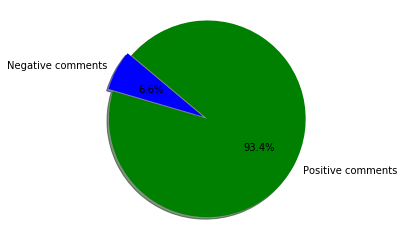

In [107]:
negative=data.polarity.sum()
positive=len(data)-negative
print("There are  ", positive, " positive comments and ", negative, " negative comments.")
labels = ['Negative comments', 'Positive comments']
sizes = [negative,positive]
colors = ['blue', 'green']
# Data to plot
explode = (0, 0.05)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

# Export file

Export the dataframe to csv with the polarities:   
    0 for positive   
    1 for negative

In [109]:
data.to_csv('../data/covid.csv') 